In [ ]:
!pip install contractions

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import contractions
from datetime import datetime, timedelta

import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

import torch
import torch.nn as nn
import torch.utils.data as data

from transformers import BertTokenizer, BertForSequenceClassification, pipeline
from scipy.special import softmax
from scipy.stats import skew

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

import plotly.express as px
import plotly.graph_objects as go
import ipywidgets as widgets
from IPython.display import display


In [ ]:
def preprocess_text (text) :

  text = text.lower()

  text = re.sub(r'https?:\/V.*[\r\n]*',' ', text)
  text = re.sub(r'www.*[\r\n]*','', text)
  text = re.sub(r'https', ' ', text)
  text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)

  text = re. sub(r'\@\w+','',text)
  text = re.sub(r'\#\w+', '', text)
  text = re.sub(r'@[a-z0-9]+', '', text)
  text = re.sub(r'#[a-z0-9]', '', text)
  text = re.sub(r'@', '', text)
  text = re.sub(r'#', '', text)

  text = text.encode('ascii', 'ignore').decode('ascii')

  text = contractions.fix(text)

  text = text. replace('%', ' percent')
  text = re. sub(r'&amp',
  'and ', text)
  text = re.sub(r'&gt', ' greater than ', text)

  text = re. sub(r'p&f', 'point and figure', text)
  text = re. sub(r's&p', 'SP500', text)
  text = re. sub(r'q&a', 'question and answer', text)
  text = re.sub(r'b/c', ' because ', text)
  text = re.sub(r'b/o', ' break out ', text)
  text = re. sub(r'p/e',
  'pe ratio', text)
  text = re.sub(r'\$[a-zA-Z]+', 'stock', text, flags=re.IGNORECASE)

  return text

In [ ]:
all_tweets = pd.read_csv('stock_tweets.csv')

In [ ]:
print(all_tweets.shape)
all_tweets.head()

(80793, 4)


,Date,Tweet,Stock Name,Company Name
0,2022-09-29 23:41:16+00:00,Mainstream media has done an amazing job at br...,TSLA,"Tesla, Inc."
1,2022-09-29 23:24:43+00:00,Tesla delivery estimates are at around 364k fr...,TSLA,"Tesla, Inc."
2,2022-09-29 23:18:08+00:00,3/ Even if I include 63.0M unvested RSUs as of...,TSLA,"Tesla, Inc."
3,2022-09-29 22:40:07+00:00,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,TSLA,"Tesla, Inc."
4,2022-09-29 22:27:05+00:00,"@RealDanODowd @Tesla Stop trying to kill kids,...",TSLA,"Tesla, Inc."


In [ ]:
print((all_tweets["Stock Name"].unique()))
stock_name = 'TSLA'
df = all_tweets[all_tweets['Stock Name'] == stock_name]
print('df.shape: ',df.shape)
sent_df = df.copy()
df.head()

['TSLA' 'MSFT' 'PG' 'META' 'AMZN' 'GOOG' 'AMD' 'AAPL' 'NFLX' 'TSM' 'KO'
 'F' 'COST' 'DIS' 'VZ' 'CRM' 'INTC' 'BA' 'BX' 'NOC' 'PYPL' 'ENPH' 'NIO'
 'ZS' 'XPEV']
df.shape:  (37422, 4)


,Date,Tweet,Stock Name,Company Name
0,2022-09-29 23:41:16+00:00,Mainstream media has done an amazing job at br...,TSLA,"Tesla, Inc."
1,2022-09-29 23:24:43+00:00,Tesla delivery estimates are at around 364k fr...,TSLA,"Tesla, Inc."
2,2022-09-29 23:18:08+00:00,3/ Even if I include 63.0M unvested RSUs as of...,TSLA,"Tesla, Inc."
3,2022-09-29 22:40:07+00:00,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,TSLA,"Tesla, Inc."
4,2022-09-29 22:27:05+00:00,"@RealDanODowd @Tesla Stop trying to kill kids,...",TSLA,"Tesla, Inc."


In [ ]:
!pip install transformers torch

In [ ]:


MODEL_NAME = "nlptown/bert-base-multilingual-uncased-sentiment"

tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
model = BertForSequenceClassification.from_pretrained(MODEL_NAME)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model=MODEL_NAME,
    tokenizer=MODEL_NAME,
    device=0 if device.type == 'cuda' else -1,
    return_all_scores=True
)

def analyze_sentiment_with_pipeline(df):
    processed_tweets = [preprocess_text(tweet) for tweet in df['Tweet']]

    results = sentiment_pipeline(processed_tweets, batch_size=32)

    sentiment_scores = []
    for res in results:
        sorted_res = sorted(res, key=lambda x: int(x['label'].split(' ')[0]))
        probabilities = [item['score'] for item in sorted_res]

        sentiment_score = sum([i * prob for i, prob in enumerate(probabilities)]) / (len(probabilities) - 1)

        scaled_score = 2 * (sentiment_score - 0.5)
        sentiment_scores.append(scaled_score)

    df['Sentiment_Score'] = sentiment_scores
    return df


sent_df = analyze_sentiment_with_pipeline(sent_df.copy())

print(sent_df[['Tweet', 'Sentiment_Score']])

Device set to use cuda:0
/usr/local/lib/python3.12/dist-packages/transformers/pipelines/text_classification.py:111: UserWarning:

`return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.



                                                   Tweet  Sentiment_Score
0      Mainstream media has done an amazing job at br...         0.106427
1      Tesla delivery estimates are at around 364k fr...        -0.204804
2      3/ Even if I include 63.0M unvested RSUs as of...        -0.503076
3      @RealDanODowd @WholeMarsBlog @Tesla Hahaha why...        -0.620934
4      @RealDanODowd @Tesla Stop trying to kill kids,...        -0.656456
...                                                  ...              ...
37417  Playing in the dirt and #chasingsunsets\n@tesl...         0.184958
37418  I agree with @freshjiva that $TSLA ‘s EV busin...        -0.357634
37419                             Hold. On. Tight. $TSLA         0.385310
37420  Get ready for a $TSLA _ _ _ _ _ _  Q3 delivery...         0.326408
37421  In other words, AMD has been giving Tesla pref...         0.671404

[37422 rows x 2 columns]


In [ ]:
sent_df.head()

,Date,Tweet,Stock Name,Company Name,Sentiment_Score
0,2022-09-29 23:41:16+00:00,Mainstream media has done an amazing job at br...,TSLA,"Tesla, Inc.",0.106427
1,2022-09-29 23:24:43+00:00,Tesla delivery estimates are at around 364k fr...,TSLA,"Tesla, Inc.",-0.204804
2,2022-09-29 23:18:08+00:00,3/ Even if I include 63.0M unvested RSUs as of...,TSLA,"Tesla, Inc.",-0.503076
3,2022-09-29 22:40:07+00:00,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,TSLA,"Tesla, Inc.",-0.620934
4,2022-09-29 22:27:05+00:00,"@RealDanODowd @Tesla Stop trying to kill kids,...",TSLA,"Tesla, Inc.",-0.656456


In [ ]:
sent_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37422 entries, 0 to 37421
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Date             37422 non-null  object 
 1   Tweet            37422 non-null  object 
 2   Stock Name       37422 non-null  object 
 3   Company Name     37422 non-null  object 
 4   Sentiment_Score  37422 non-null  float64
dtypes: float64(1), object(4)
memory usage: 2.7+ MB


In [ ]:
sent_df['Date'] = pd.to_datetime(sent_df['Date'], errors='coerce')

print(sent_df['Date'].dtype)

datetime64[ns, UTC]


In [ ]:
daily_sentiment = sent_df.groupby(sent_df['Date'].dt.date).agg({

    'Sentiment_Score': 'mean'
}).reset_index()

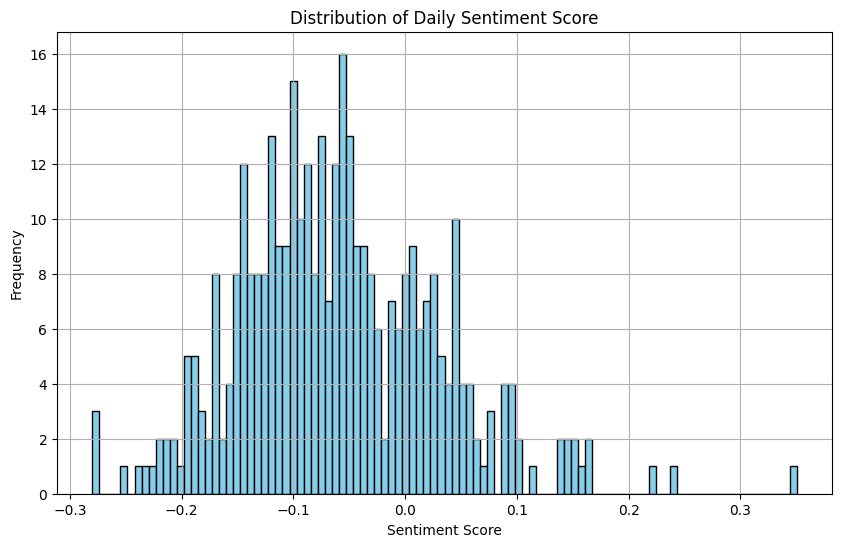

In [ ]:

# Plotting the distribution of 'Sentiment_Score'
plt.figure(figsize=(10, 6))
plt.hist(daily_sentiment['Sentiment_Score'], bins=100, color='skyblue', edgecolor='black')
plt.title('Distribution of Daily Sentiment Score')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [ ]:

daily_sentiment['Date'] = pd.to_datetime(daily_sentiment['Date'], errors='coerce')


print(daily_sentiment['Date'].dtype)

datetime64[ns]


In [ ]:
all_stocks = pd.read_csv('stock_yfinance_data.csv')
print(all_stocks.shape)
all_stocks.head()

(6300, 8)


,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name
0,2021-09-30,260.333344,263.043335,258.333344,258.493347,258.493347,53868000,TSLA
1,2021-10-01,259.466675,260.260010,254.529999,258.406677,258.406677,51094200,TSLA
2,2021-10-04,265.500000,268.989990,258.706665,260.510010,260.510010,91449900,TSLA
3,2021-10-05,261.600006,265.769989,258.066681,260.196655,260.196655,55297800,TSLA
4,2021-10-06,258.733337,262.220001,257.739990,260.916656,260.916656,43898400,TSLA


In [ ]:
stock_df = all_stocks[all_stocks['Stock Name'] == stock_name]
stock_df['Date'] = pd.to_datetime(stock_df['Date'])

/tmp/ipython-input-1088722936.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
print(stock_df.info())
final_df = pd.merge(stock_df, daily_sentiment, left_on='Date', right_on='Date', how='inner')
print(final_df.head())

<class 'pandas.core.frame.DataFrame'>
Index: 252 entries, 0 to 251
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        252 non-null    datetime64[ns]
 1   Open        252 non-null    float64       
 2   High        252 non-null    float64       
 3   Low         252 non-null    float64       
 4   Close       252 non-null    float64       
 5   Adj Close   252 non-null    float64       
 6   Volume      252 non-null    int64         
 7   Stock Name  252 non-null    object        
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 17.7+ KB
None
        Date        Open        High         Low       Close   Adj Close  \
0 2021-09-30  260.333344  263.043335  258.333344  258.493347  258.493347   
1 2021-10-01  259.466675  260.260010  254.529999  258.406677  258.406677   
2 2021-10-04  265.500000  268.989990  258.706665  260.510010  260.510010   
3 2021-10-05  261.600006  265.

In [ ]:
final_df.to_csv('my_file.csv', index=False)


In [ ]:
loaded_df = pd.read_csv('my_file.csv')
data = loaded_df.copy()
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name,Sentiment_Score
0,2021-09-30,260.333344,263.043335,258.333344,258.493347,258.493347,53868000,TSLA,-0.131964
1,2021-10-01,259.466675,260.260010,254.529999,258.406677,258.406677,51094200,TSLA,-0.059853
2,2021-10-04,265.500000,268.989990,258.706665,260.510010,260.510010,91449900,TSLA,-0.113505
3,2021-10-05,261.600006,265.769989,258.066681,260.196655,260.196655,55297800,TSLA,-0.110149
4,2021-10-06,258.733337,262.220001,257.739990,260.916656,260.916656,43898400,TSLA,-0.027656


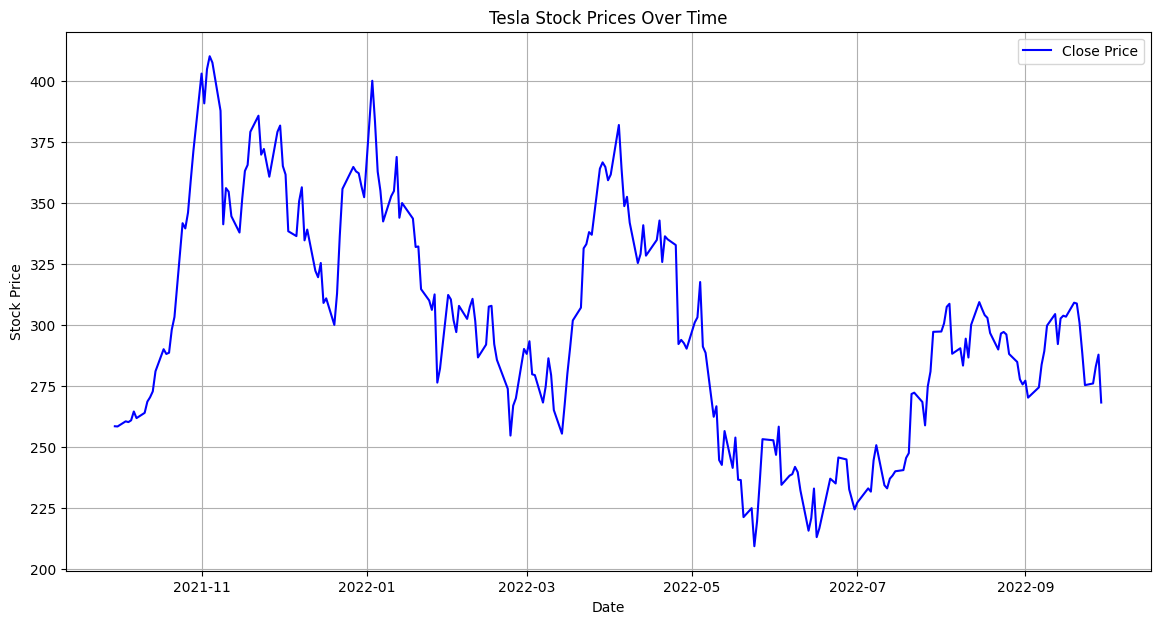

In [ ]:
df = data.copy()
df['Date'] = pd.to_datetime(df['Date'])
plt.figure(figsize=(14, 7))
plt.plot(df['Date'], df['Close'], label="Close Price", color='blue')
plt.title("Tesla Stock Prices Over Time")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.grid()
plt.show()

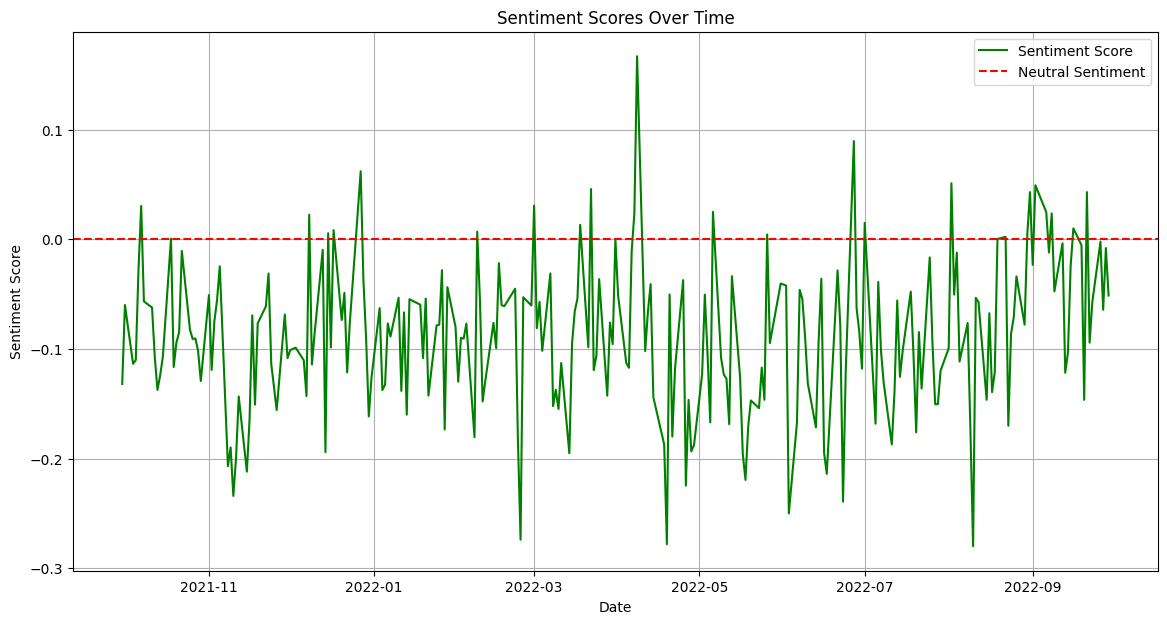

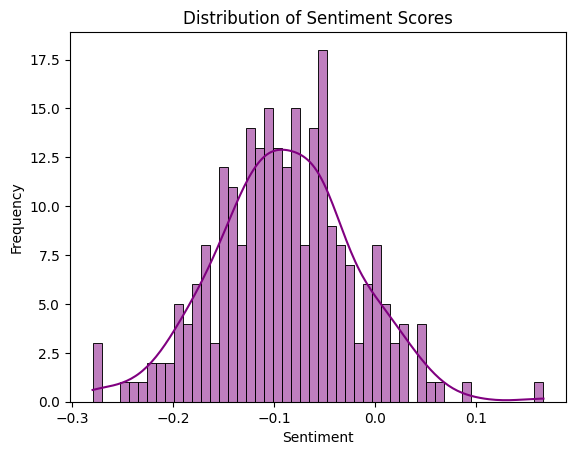

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(df['Date'], df['Sentiment_Score'], label="Sentiment Score", color='green')
plt.axhline(y=0, color='red', linestyle='--', label="Neutral Sentiment")
plt.title("Sentiment Scores Over Time")
plt.xlabel("Date")
plt.ylabel("Sentiment Score")
plt.legend()
plt.grid()
plt.show()

# Distribution of sentiment scores
sns.histplot(df['Sentiment_Score'], bins=50, kde=True, color='purple')
plt.title("Distribution of Sentiment Scores")
plt.xlabel("Sentiment")
plt.ylabel("Frequency")
plt.show()


In [ ]:
df.describe

<bound method NDFrame.describe of           Date        Open        High         Low       Close   Adj Close  \
0   2021-09-30  260.333344  263.043335  258.333344  258.493347  258.493347   
1   2021-10-01  259.466675  260.260010  254.529999  258.406677  258.406677   
2   2021-10-04  265.500000  268.989990  258.706665  260.510010  260.510010   
3   2021-10-05  261.600006  265.769989  258.066681  260.196655  260.196655   
4   2021-10-06  258.733337  262.220001  257.739990  260.916656  260.916656   
..         ...         ...         ...         ...         ...         ...   
247 2022-09-23  283.089996  284.500000  272.820007  275.329987  275.329987   
248 2022-09-26  271.829987  284.089996  270.309998  276.010010  276.010010   
249 2022-09-27  283.839996  288.670013  277.510010  282.940002  282.940002   
250 2022-09-28  283.079987  289.000000  277.570007  287.809998  287.809998   
251 2022-09-29  282.760010  283.649994  265.779999  268.209991  268.209991   

       Volume Stock Name  Sentiment_Score  
0    53868000       TSLA        -0.131964  
1    51094200       TSLA        -0.059853  
2    91449900       TSLA        -0.113505  
3    55297800       TSLA        -0.110149  
4    43898400       TSLA        -0.027656  
..        ...        ...              ...  
247  63748400       TSLA        -0.057113  
248  58076900       TSLA        -0.002073  
249  61925200       TSLA        -0.064264  
250  54664800       TSLA        -0.007974  
251  77620600       TSLA        -0.051258  

[252 rows x 9 columns]>

In [ ]:
df1=df.copy()

In [ ]:
df1['Sentiment_Score'] = df1['Sentiment_Score'].fillna(0)
endog_data = df1['Close']
scaler = MinMaxScaler()
exog_data = pd.DataFrame(scaler.fit_transform(df1[['Sentiment_Score']]),
                         index=df1.index,
                         columns=['Sentiment_Score_Scaled'])

p, d, q = 1, 1, 1

print("Fitting ARIMAX model...")
arimax_model = ARIMA(endog=endog_data, exog=exog_data, order=(p, d, q))
model_fit = arimax_model.fit()
print("Model fitting complete.")
predictions = model_fit.predict(start=0, end=len(df1)-1, typ='levels', exog=exog_data)
df1['ma_20'] = predictions

df1['z_score'] = (df1['Close'] - df1['ma_20']) / df1['Close'].rolling(window=7, min_periods=1).std()
print(df1[['Close', 'ma_20', 'z_score']].head())

Fitting ARIMAX model...
Model fitting complete.
        Close       ma_20    z_score
0  258.493347    4.745333        NaN
1  258.406677  260.804989 -39.133814
2  260.510010  256.741847   3.166179
3  260.196655  260.506738  -0.280144
4  260.916656  262.898482  -1.688324


In [ ]:
# # Calculate moving averages
# df1['ma_20'] = df1['Close'].rolling(window=20,min_periods=1).mean()
# df1['z_score'] = (df1['Close'] - df1['ma_20']) / df1['Close'].rolling(window=7, min_periods=1).std()

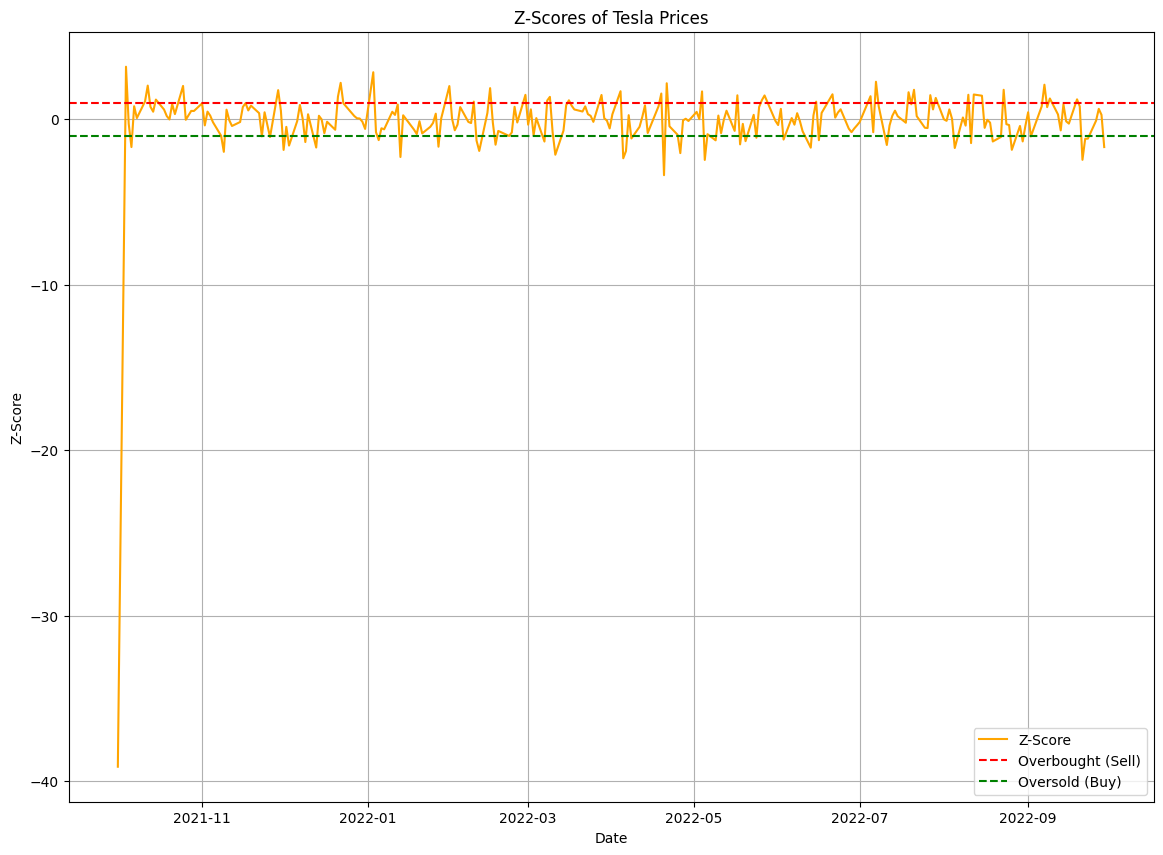

In [ ]:
# Plot z-scores
plt.figure(figsize=(14, 10))
plt.plot(df1['Date'], df1['z_score'], label="Z-Score", color='orange')
plt.axhline(y=1, color='red', linestyle='--', label="Overbought (Sell)")
plt.axhline(y=-1, color='green', linestyle='--', label="Oversold (Buy)")
plt.title("Z-Scores of Tesla Prices")
plt.xlabel("Date")
plt.ylabel("Z-Score")
plt.legend()
plt.grid()
plt.show()

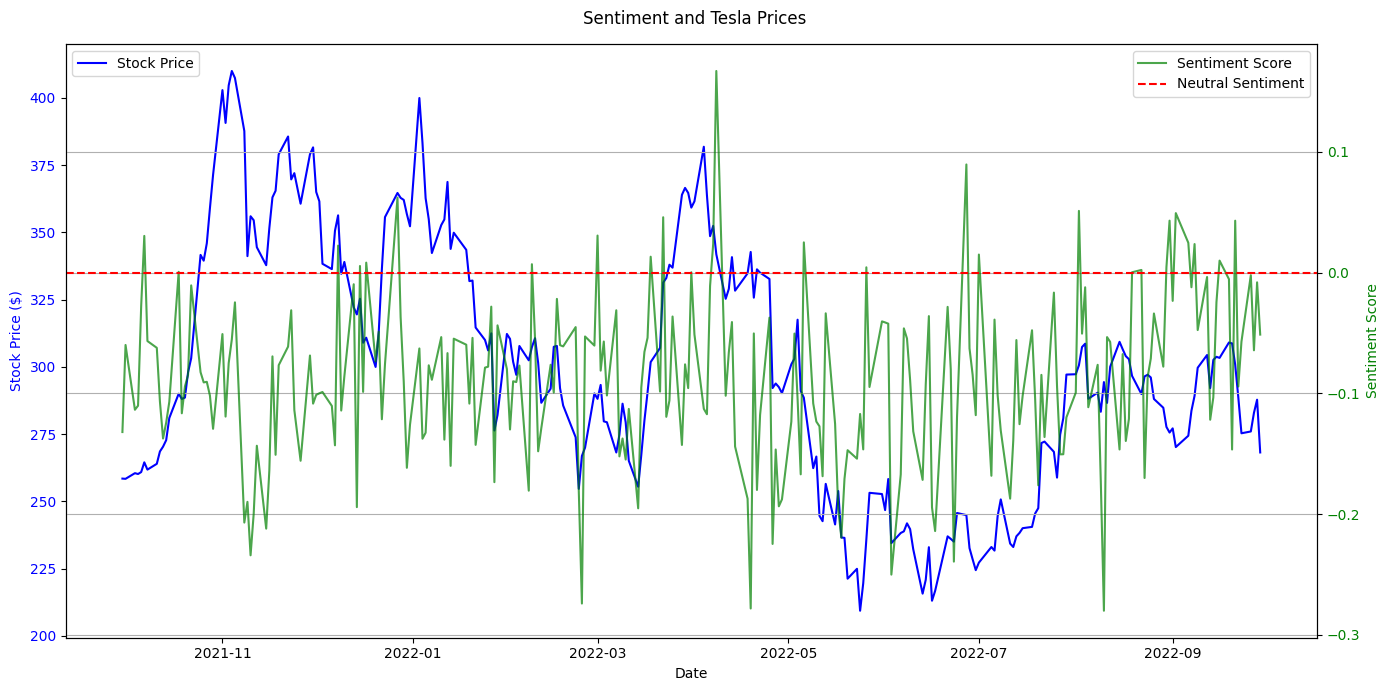

In [ ]:
fig, ax1 = plt.subplots(figsize=(14, 7))


ax1.plot(df1['Date'], df1['Close'], label="Stock Price", color='blue')
ax1.set_xlabel("Date")
ax1.set_ylabel("Stock Price ($)", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')


ax2 = ax1.twinx()
ax2.plot(df1['Date'], df1['Sentiment_Score'], label="Sentiment Score", color='green', alpha=0.7)
ax2.axhline(y=0, color='red', linestyle='--', label="Neutral Sentiment")
ax2.set_ylabel("Sentiment Score", color='green')
ax2.tick_params(axis='y', labelcolor='green')


fig.suptitle("Sentiment and Tesla Prices")
fig.tight_layout()
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

plt.grid()
plt.show()


In [ ]:
df1['lagged_sentiment'] = df1.groupby('Stock Name')['Sentiment_Score'].shift(1)
df1['sentiment_volatility'] = df1.groupby('Stock Name')['Sentiment_Score'].rolling(window=3).std().reset_index(0, drop=True)

for lag in [1, 3, 7, 14]:
    df1[f'future_returns_lag_{lag}'] = df1.groupby('Stock Name')['Close'].shift(-lag) / df1['Close'] - 1

features_to_correlate = [
    'Sentiment_Score',
    'sentiment_volatility',
    'lagged_sentiment',
    'future_returns_lag_1',
    'future_returns_lag_3',
    'future_returns_lag_7',
    'future_returns_lag_14'
]

correlation = df1[features_to_correlate].corr()

import plotly.express as px
fig = px.imshow(
    correlation,
    text_auto=".2f",
    color_continuous_scale=px.colors.sequential.RdBu,
    labels=dict(color="Correlation"),
    title="Correlation Matrix with Improved Features"
)
fig.show()

In [ ]:
# Check for skewness before applying log-transformation of scores

skew_value = skew(df1['Sentiment_Score'].dropna())
print(f"Skewness: {skew_value}")

Skewness: 0.05800064609453851


In [ ]:

# Convert 'Date' column to datetime format
df1['Date'] = pd.to_datetime(df1['Date'])

def plot_dashboard(start_date, end_date):
    """Plot the stock price and sentiment dashboard"""
    # Filter data
    filtered_df = df1[(df1['Date'] >= pd.to_datetime(start_date)) &
                      (df1['Date'] <= pd.to_datetime(end_date))]

    # Create figure with dual y-axes
    fig = go.Figure()

    # Add stock price trace
    fig.add_trace(go.Scatter(
        x=filtered_df['Date'],
        y=filtered_df['Close'],
        mode='lines',
        name='Stock Price',
        line=dict(color='blue', width=2)
    ))

    # Add sentiment score trace
    fig.add_trace(go.Scatter(
        x=filtered_df['Date'],
        y=filtered_df['Sentiment_Score'],
        mode='lines',
        name='Sentiment Score',
        line=dict(color='green', width=2),
        opacity=0.7,
        yaxis='y2'
    ))

    # Update layout
    fig.update_layout(
        title={
            'text': "Tesla Stock Price and Sentiment Dashboard",
            'x': 0.5,
            'xanchor': 'center',
            'font': {'size': 24}
        },
        xaxis_title="Date",
        yaxis=dict(
            title="Stock Price ($)",
            titlefont=dict(color='blue'),
            tickfont=dict(color='blue')
        ),
        yaxis2=dict(
            title="Sentiment Score",
            overlaying="y",
            side="right",
            titlefont=dict(color='green'),
            tickfont=dict(color='green')
        ),
        legend=dict(
            x=0.5,
            y=1.15,
            orientation="h",
            xanchor='center'
        ),
        margin=dict(l=60, r=60, t=100, b=60),
        height=600,
        hovermode='x unified'
    )

    fig.show()

# Create date picker widgets
start_date_picker = widgets.DatePicker(
    description='Start Date:',
    value=df1['Date'].min().date(),
    disabled=False,
    style={'description_width': 'initial'}
)

end_date_picker = widgets.DatePicker(
    description='End Date:',
    value=df1['Date'].max().date(),
    disabled=False,
    style={'description_width': 'initial'}
)

# Create update button
update_button = widgets.Button(
    description="Update Dashboard",
    button_style='success',
    tooltip='Click to update the chart',
    icon='refresh'
)

# Define button click handler
def on_button_click(b):
    plot_dashboard(start_date_picker.value, end_date_picker.value)

update_button.on_click(on_button_click)

# Create layout
controls = widgets.HBox([start_date_picker, end_date_picker, update_button])

# Display widgets and initial plot
print("=" * 80)
print("TESLA STOCK PRICE AND SENTIMENT ANALYSIS DASHBOARD")
print("=" * 80)
display(controls)
print("\n")
plot_dashboard(df1['Date'].min(), df1['Date'].max())

TESLA STOCK PRICE AND SENTIMENT ANALYSIS DASHBOARD


In [ ]:


def preprocess_data_zscore(df, feature_columns, target_column, sequence_length, exclude_columns=[]):
    feature_scaler = StandardScaler()
    target_scaler = StandardScaler()

    columns_to_scale = [col for col in feature_columns if col not in exclude_columns]
    df[columns_to_scale] = feature_scaler.fit_transform(df[columns_to_scale])
    df[target_column] = target_scaler.fit_transform(df[[target_column]])


    # Create sequences for LSTM
    X, y = [], []
    for i in range(len(df) - sequence_length):
        X.append(df[feature_columns].iloc[i:i+sequence_length].values)
        y.append(df[target_column].iloc[i+sequence_length])

    X = torch.tensor(np.array(X), dtype=torch.float32)
    y = torch.tensor(np.array(y), dtype=torch.float32)
    return X, y, feature_scaler, target_scaler

# Drop rows with NaN values
df1 = df1.dropna()


sequence_length = 20
feature_columns = ['Open', 'High', 'Low', 'Close', 'Volume',
                   'ma_20', 'z_score', 'future_returns_lag_1', 'future_returns_lag_3', 'sentiment_volatility']
target_column = 'future_returns_lag_7'

exclude_columns = ['sentiment_volatility', 'Sentiment_Score']

# Prepare data
X, y, scaler, target_scaler = preprocess_data_zscore(df1, feature_columns, target_column, sequence_length, exclude_columns)

# Train-test split
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [ ]:
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

In [ ]:
# --- 1. Define Bidirectional LSTM Model ---
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(
            input_dim,
            hidden_dim,
            num_layers,
            batch_first=True,
            dropout=dropout,
            bidirectional=True  # <-- Set to True
        )
        # The output from LSTM is hidden_dim * 2 (forward + backward)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        # We take the output of the last time step
        out = self.fc(out[:, -1, :])
        return out


# --- Model Parameters ---
input_dim = len(feature_columns)
hidden_dim = 64
output_dim = 1
num_layers = 2
dropout = 0.2

# --- 2. Define Training Function (with Validation & Early Stopping) ---
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, patience=5):
    best_val_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()

            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch.unsqueeze(1))

            # Check for NaNs
            if torch.isnan(loss):
                print(f"NaN loss detected at epoch {epoch+1}. Skipping batch.")
                continue

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0);
            optimizer.step()
            train_loss += loss.item()

        # --- Validation Loop ---
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                y_pred_val = model(X_batch)
                v_loss = criterion(y_pred_val, y_batch.unsqueeze(1))
                if not torch.isnan(v_loss):
                    val_loss += v_loss.item()

        train_loss_avg = train_loss / len(train_loader)
        val_loss_avg = val_loss / len(val_loader)

        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss_avg:.6f}, Val Loss: {val_loss_avg:.6f}")

        # --- Early Stopping Logic ---
        if val_loss_avg < best_val_loss:
            best_val_loss = val_loss_avg
            torch.save(model.state_dict(), 'best_model.pth') # Save the best model
            epochs_no_improve = 0
            print("Validation loss decreased. Saving model.")
        else:
            epochs_no_improve += 1
            print(f"Validation loss did not improve. {epochs_no_improve}/{patience}")

        if epochs_no_improve >= patience:
            print(f"Early stopping triggered after {patience} epochs with no improvement.")
            break

    print("Training complete. Loading best model.")
    # Load the best performing model
    model.load_state_dict(torch.load('best_model.pth'))


# --- 3. Initialize Model, Loss, Optimizer ---
model = LSTMModel(input_dim, hidden_dim, output_dim, num_layers, dropout)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # <-- Improved LR

# --- 4. Train Model ---
num_epochs = 100
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, patience=10)

# --- 5. Evaluate Model (on Test Set) ---
model.eval()
all_preds = []
all_actuals = []

with torch.no_grad():
    for X_batch, y_batch in test_loader: # <-- Use test_loader
        y_pred_test = model(X_batch).squeeze()
        all_preds.append(y_pred_test.numpy())
        all_actuals.append(y_batch.numpy())

# Flatten the lists
y_pred_flat = np.concatenate(all_preds).flatten()
y_actual_flat = np.concatenate(all_actuals).flatten()

# Inverse transform to get original scale
y_pred = target_scaler.inverse_transform(y_pred_flat.reshape(-1, 1)).flatten()
y_actual = target_scaler.inverse_transform(y_actual_flat.reshape(-1, 1)).flatten()

# --- Calculate Metrics ---
rmse = np.sqrt(np.mean((y_pred - y_actual) ** 2))
# Calculate directional accuracy (predicting positive or negative return)
directional_accuracy = np.mean(np.sign(y_pred) == np.sign(y_actual))

print(f"\n--- Test Results (Best Model) ---")
print(f"Test RMSE: {rmse:.4f}")
print(f"Directional Accuracy: {directional_accuracy:.2%}")


Epoch 1/100, Train Loss: 0.917506, Val Loss: 0.382021
Validation loss decreased. Saving model.
Epoch 2/100, Train Loss: 0.851884, Val Loss: 0.387734
Validation loss did not improve. 1/10
Epoch 3/100, Train Loss: 0.773428, Val Loss: 0.397764
Validation loss did not improve. 2/10
Epoch 4/100, Train Loss: 0.757763, Val Loss: 0.405285
Validation loss did not improve. 3/10
Epoch 5/100, Train Loss: 0.746649, Val Loss: 0.407034
Validation loss did not improve. 4/10
Epoch 6/100, Train Loss: 0.769821, Val Loss: 0.400973
Validation loss did not improve. 5/10
Epoch 7/100, Train Loss: 0.731490, Val Loss: 0.390742
Validation loss did not improve. 6/10
Epoch 8/100, Train Loss: 0.714242, Val Loss: 0.385440
Validation loss did not improve. 7/10
Epoch 9/100, Train Loss: 0.715005, Val Loss: 0.381378
Validation loss decreased. Saving model.
Epoch 10/100, Train Loss: 0.724196, Val Loss: 0.376569
Validation loss decreased. Saving model.
Epoch 11/100, Train Loss: 0.699750, Val Loss: 0.367812
Validation loss

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
threshold = 0.02
initial_balance = 10000
stop_loss_pct = 0.03
take_profit_pct = 2
position = 0
balance = initial_balance
portfolio = []

# Validate data
y_actual = np.maximum(y_actual, 0.01)
y_pred = np.maximum(y_pred, 0.01)

# Smooth predictions to reduce noise
y_pred_smoothed = np.convolve(y_pred, np.ones(3) / 3, mode='same')

for i in range(len(y_pred_smoothed) - 1):
    predicted_change = (y_pred_smoothed[i + 1] - y_pred_smoothed[i]) / y_pred_smoothed[i]
    current_price = y_actual[i]

    # Dynamic threshold based on historical volatility
    volatility = np.std(y_actual[:i + 1]) if i > 10 else 0.02
    dynamic_threshold = max(threshold, volatility)

    # Trading logic
    if position == 0:  # No position
        trade_balance = 0.1 * balance  # Allocate 10% of balance for trading
        if predicted_change > dynamic_threshold:  # Buy signal
            position = trade_balance / current_price
            balance -= trade_balance
            stop_loss_price = current_price * (1 - stop_loss_pct)
            take_profit_price = current_price * (1 + take_profit_pct)
            print(f"Buying at {current_price:.2f}, Position: {position:.2f} shares, Stop-Loss: {stop_loss_price:.2f}, Take-Profit: {take_profit_price:.2f}")
        elif predicted_change < -dynamic_threshold:  # Short signal
            position = -trade_balance / current_price
            balance -= trade_balance
            stop_loss_price = current_price * (1 + stop_loss_pct)
            take_profit_price = current_price * (1 - take_profit_pct)
            print(f"Short-selling at {current_price:.2f}, Position: {position:.2f} shares, Stop-Loss: {stop_loss_price:.2f}, Take-Profit: {take_profit_price:.2f}")

    elif position > 0:  # Long position
        if current_price <= stop_loss_price:  # Stop-loss hit
            balance += position * current_price
            position = 0
            print(f"Selling at {current_price:.2f} (Stop-Loss), Balance: {balance:.2f}")
        elif current_price >= take_profit_price:  # Take-profit hit
            balance += position * current_price
            position = 0
            print(f"Selling at {current_price:.2f} (Take-Profit), Balance: {balance:.2f}")

    elif position < 0:  # Short position
        if current_price >= stop_loss_price:  # Stop-loss hit for short
            balance -= position * current_price
            position = 0
            print(f"Covering short at {current_price:.2f} (Stop-Loss), Balance: {balance:.2f}")
        elif current_price <= take_profit_price:  # Take-profit hit for short
            balance -= position * current_price
            position = 0
            print(f"Covering short at {current_price:.2f} (Take-Profit), Balance: {balance:.2f}")

    # Update portfolio value
    portfolio.append(balance + (position * current_price if position != 0 else 0))

# Final balance
final_balance = balance + (position * y_actual[-1] if position != 0 else 0)
print(f"Final Portfolio Value: {final_balance:.2f}")

Buying at 0.17, Position: 6039.26 shares, Stop-Loss: 0.16, Take-Profit: 0.50
Selling at 0.15 (Stop-Loss), Balance: 9895.97
Buying at 0.13, Position: 7836.74 shares, Stop-Loss: 0.12, Take-Profit: 0.38
Selling at 0.08 (Stop-Loss), Balance: 9519.73
Buying at 0.14, Position: 6688.13 shares, Stop-Loss: 0.14, Take-Profit: 0.43
Selling at 0.09 (Stop-Loss), Balance: 9196.85
Buying at 0.01, Position: 91968.50 shares, Stop-Loss: 0.01, Take-Profit: 0.03
Selling at 0.08 (Take-Profit), Balance: 15554.80
Buying at 0.10, Position: 14890.18 shares, Stop-Loss: 0.10, Take-Profit: 0.31
Selling at 0.05 (Stop-Loss), Balance: 14804.04
Short-selling at 0.07, Position: -21615.54 shares, Stop-Loss: 0.07, Take-Profit: -0.07
Final Portfolio Value: 12669.17


In [ ]:
Profits = final_balance - initial_balance
print(f"Profits: {Profits:.2f}")

Profits: 2669.17
